# Linear Factor Models

## Load Packages and Extra Functions

In [1]:
using Printf, LinearAlgebra, Statistics, DelimitedFiles

include("jlFiles/printmat.jl")

include("jlFiles/NWFn.jl")
include("jlFiles/OlsFn.jl")
include("jlFiles/OlsSureFn_EF.jl")

OlsSureFn

In [2]:
using Plots

#pyplot(size=(600,400))
gr(size=(480,320))
default(fmt = :svg)

## Loading Data

In [3]:
xx   = readdlm("Data/FFmFactorsPs.csv",',',skipstart=1)
Rme  = xx[:,2]
RSMB = xx[:,3]                #small minus big firms
RHML = xx[:,4]                #high minus low book-to-market ratio
Rf   = xx[:,5]                #interest rate


xx = readdlm("Data/FF25Ps.csv",',')  #no header line: x is matrix
R  = xx[:,2:end]                     #returns for 25 FF portfolios
Re = R .- Rf                         #excess returns for the 25 FF portfolios
xx = nothing

(T,n) = size(Re)                     #no. obs and  no. test assets

(388, 25)

# Testing alpha from Time Series Regressions


With $n$ test assets and $K$ excess return factors, the linear factor model is

$
R_{t}^{e}=\alpha+\beta f_{t}+\varepsilon_{t},
$

and the testable hypothesis is that all alphas are zero.

In [4]:
F         = [ones(T) Rme RSMB RHML]       #factors, constant and 3 FF factors
FNames    = ["c","Rme","RSMB","RHML"]     #names, used for printing

(b,epsM,) = OlsSureFn(Re,F)               #point estimates and residuals
α         = b[1,:]                        #n vector
β         = b[2:end,:]'                   #nxK matrix 

g = fill(NaN,(T,size(F,2)*n))             #moment conditions, regressors*residual
for t = 1:T
  g[t,:] = kron(F[t:t,:],epsM[t:t,:])
end
S0   = NWFn(g,0)                          #ACov(sqrt(T)*gbar)
Sxx  = F'F/T
D0_1 = -kron(inv(Sxx),I(n))             #inverse of Jacobian
V    = D0_1*S0*D0_1'                      #covariance matrix(all coeffs)

WaldStat  = α'inv(V[1:n,1:n]/T)*α         #test if all alpha=0

printblue("Testing α = 0:")
printmat(Any[WaldStat,length(α),34.38],rowNames=["test statistic","df","10% critical value"])

Testing α = 0:
test statistic       162.011
df                    25    
10% critical value    34.380



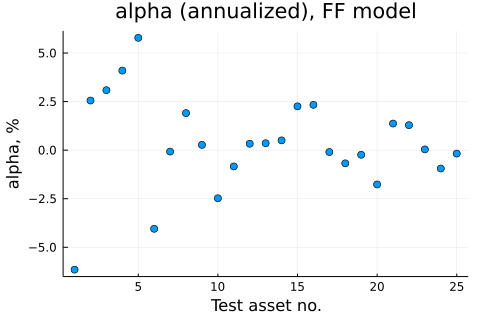

In [5]:
scatter( α*12,
         legend = false,
         title = "alpha (annualized), FF model",
         xlabel = "Test asset no.",
         ylabel = "alpha, %" )

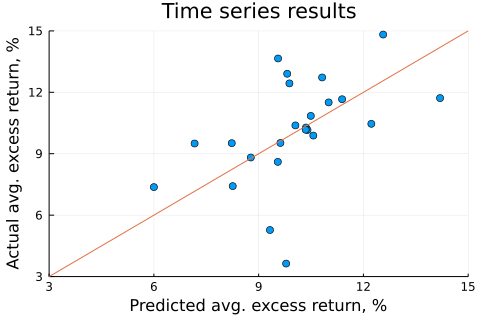

In [6]:
ERe     = vec(mean(Re,dims=1))         #n vector, average excess returns
EF      = vec(mean(F[:,2:end],dims=1)) #K vector, average values of factors
ReHatTS = β*EF                         #predicted average returns, setting alpha=0 

scatter( ReHatTS*12,ERe*12,
         legend = false,
         xlims = (3,15),
         ylims = (3,15),
         title = "Time series results",
         xlabel = "Predicted avg. excess return, %",
         ylabel = "Actual avg. excess return, %" )

plot!([0;20],[0,20])

# Cross-Sectional Regressions

The following code from uses GMM to test $\operatorname*{E}R^{e}=\beta \lambda$ from an FF model---the case of
"General Factors".

(The factors happen to be excess returns,
but that does not stop us from applying the method for general factors.) 

The code applies GMM without a weighting function. Instead, an $A$ matrix is defined
such that $A\bar{g}=\mathbf{0}$ becomes the effective moment conditions. The
matrix is chosen to make the factor risk premia ($\lambda$) the same as in the
old-fashioned cross-sectional regressions.

## Getting the Point Estimates

In [7]:
K         = size(F,2) - 1                 #number of (non-constant) factors
(b,epsM,) = OlsSureFn(Re,F)

ERe = vec(mean(Re,dims=1))
β   = b[2:end,:]'                         #nxK
θ   = β'
λ   = (θ*β)\(θ*ERe)       #cross-sectional estimate of price of factor risk

printblue("Fitted risk premia and sample averages (*12):\n")
printmat([λ EF]*12,colNames=["λ","Ef"],rowNames=FNames[2:end])

printstyled("large differences casts doubts on the cross-sectional regression",
            color=:red,bold=true)

Fitted risk premia and sample averages (*12):

             λ        Ef
Rme      6.800     7.223
RSMB     3.026     2.500
RHML     5.269     3.960

large differences casts doubts on the cross-sectional regression

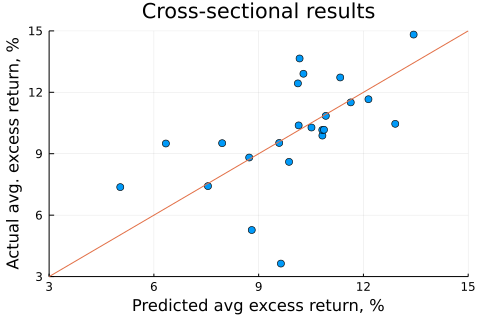

In [8]:
ReHatCR = β*λ   #predicted average returns, setting alpha=0 

p1 = scatter( ReHatCR*12,ERe*12,
              legend = false,
              xlims = (3,15),
              ylims = (3,15),
              title = "Cross-sectional results",
              xlabel = "Predicted avg excess return, %",
              ylabel = "Actual avg. excess return, %" )
plot!([0;20],[0,20])
display(p1)

## Comparing the Cross-Sectional and Time-Series Results

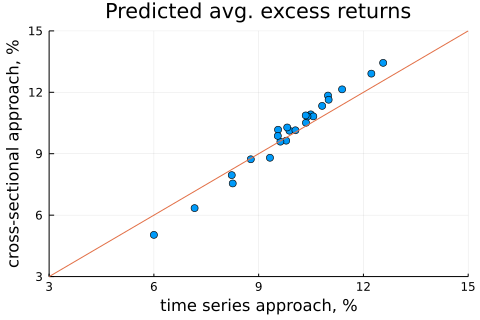

In [9]:
p1 = scatter( ReHatTS*12,ReHatCR*12,
              legend = false,
              xlim = (3,15),
              ylim = (3,15),
              title = "Predicted avg. excess returns",
              xlabel = "time series approach, %",
              ylabel = "cross-sectional approach, %" )
plot!([0;20],[0,20])
display(p1)

## Testing the Cross-Sectional Results

In [10]:
g = fill(NaN,(T,size(F,2)*n))           #moment conditions, regressors*residual
for t = 1:T
  g[t,:] = kron(F[t:t,:],epsM[t:t,:])
end
g = [g (Re .- (β*λ)')]                 #moment conditions, Txq 

p = length(α) + length(β) + length(λ)       #no. parameters
q = size(g,2)                               #no. moment conditions

gbar = vec(mean(g,dims=1))

printblue("The (average) sample moment conditions are (reshaped as n x (1+K+1)):\n")
colNames = [[string("ϵ*",FNames[i]) for i=1:K+1];"Re-βλ"]
rowNames = [string("asset ",i) for i=1:n]
printmat(reshape(gbar,n,K+2);colNames,rowNames)   # ; since keywords with same name

The (average) sample moment conditions are (reshaped as n x (1+K+1)):

               ϵ*c     ϵ*Rme    ϵ*RSMB    ϵ*RHML     Re-βλ
asset 1     -0.000    -0.000    -0.000    -0.000    -0.500
asset 2     -0.000    -0.000    -0.000     0.000     0.193
asset 3     -0.000    -0.000    -0.000     0.000     0.219
asset 4     -0.000    -0.000    -0.000     0.000     0.290
asset 5     -0.000    -0.000    -0.000     0.000     0.411
asset 6      0.000     0.000     0.000    -0.000    -0.294
asset 7      0.000     0.000    -0.000    -0.000    -0.019
asset 8     -0.000    -0.000    -0.000     0.000     0.116
asset 9     -0.000     0.000    -0.000     0.000    -0.040
asset 10    -0.000    -0.000    -0.000    -0.000    -0.302
asset 11    -0.000    -0.000    -0.000     0.000    -0.011
asset 12     0.000     0.000    -0.000    -0.000     0.020
asset 13     0.000     0.000     0.000     0.000    -0.006
asset 14    -0.000    -0.000    -0.000     0.000    -0.011
asset 15    -0.000    -0.000    -0.000     0

In [11]:
S0   = NWFn(g,0)
Sxx  = F'F/T
D0LL = kron([0 λ'],I(n))             #lower left of D0
D0   = - [kron(Sxx,I(n)) zeros(n*(1+K),K);
          D0LL             β           ]

A    = [I     zeros(n*(1+K),n);
        zeros(K,n*(1+K)) θ ]

Psia = I - D0*inv(A*D0)*A
Psi3 = Psia*S0*Psia'                          #Cov[sqrt(T)*gbar], rank q-p

WaldStat  = gbar'pinv(Psi3/T)*gbar            #test of moment conditions

printblue("\nTesting ERe = βλ:")
printmat(Any[WaldStat,(q-p),30.81],rowNames=["test statistic","df","10% critical value"])


Testing ERe = βλ:
test statistic       155.261
df                    22    
10% critical value    30.810



# Fama-MacBeth Approach

In [12]:
b, = OlsSureFn(Re,F)               #point estimates
β  = b[2:end,:]'                   #nxK matrix

K = size(β,2)
T = size(Re,1)

388

In [13]:
λ = fill(NaN,(T,K))
ϵ = fill(NaN,(T,n))
for t = 1:T                          #loop over time periods
    (λ_t,ϵ_t,) = OlsFn(Re[t,:],β)      #same as β\Re[t,:]
    λ[t,:] = λ_t                       #estimated coefficients
    ϵ[t,:] = ϵ_t                       #residuals
end

In [14]:
avg_λ = vec(mean(λ,dims=1))            #time-averages
avg_ϵ = vec(mean(ϵ,dims=1))

var_avg_ϵ = vec(var(ϵ,dims=1)/T)       #variances of the time averages
var_avg_λ = vec(var(λ,dims=1)/T)

printblue("\nTime averages of FMB estimates (*12):\n")
xut = [avg_λ sqrt.(var_avg_λ)]*12
printmat(xut,colNames=["λ","Std(λ)"],rowNames=FNames[2:end])

printstyled("Compare the λ estimates from cross-sectional (above) and FMB",color=:red,bold=true)


Time averages of FMB estimates (*12):

             λ    Std(λ)
Rme      6.800     2.904
RSMB     3.026     2.263
RHML     5.269     2.034

Compare the λ estimates from cross-sectional (above) and FMB

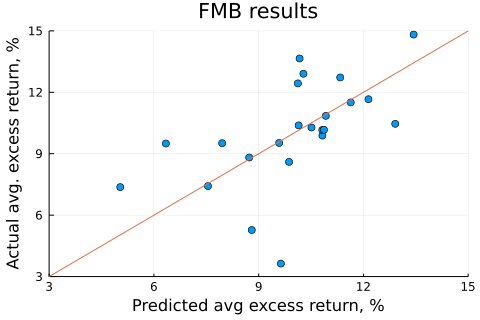

In [15]:
ReHatFMB = β*avg_λ   #predicted average returns

p1 = scatter( ReHatFMB*12,ERe*12,
              legend = false,
              xlim = (3,15),
              ylim = (3,15),
              title = "FMB results",
              xlabel = "Predicted avg excess return, %",
              ylabel = "Actual avg. excess return, %" )
plot!([0;20],[0,20])
display(p1)